In [1]:
#pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotnine import ggplot, aes, geom_count ,geom_violin ,geom_tile,scale_fill_gradient2
import scikitplot as skplt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier , RandomForestClassifier
#from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix as cm, f1_score, roc_auc_score ,classification_report
from sklearn.feature_selection import RFE, SequentialFeatureSelector

from imblearn.over_sampling import SMOTE

# Import data

In [3]:
sample_sub = pd.read_csv('sample_submission.csv')
bank_train_data = pd.read_csv('train.csv')
bank_test_data = pd.read_csv('test.csv')

In [4]:
bank_train_data.head(10)

,id,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,subscribe
0,22570,46,blue-collar,married,primary,no,4944,yes,no,cellular,14,may,108,1,356,2,failure,no
1,38062,34,management,single,tertiary,no,2115,no,no,cellular,16,nov,205,1,93,3,other,yes
2,19593,31,blue-collar,single,secondary,no,1151,yes,no,cellular,29,apr,341,1,-1,0,NaN,yes
3,36247,33,self-employed,single,tertiary,no,2730,yes,no,telephone,6,jun,826,2,-1,0,NaN,no
4,32127,44,management,married,tertiary,yes,-171,no,no,cellular,22,aug,402,2,-1,0,NaN,no
5,18571,32,management,single,tertiary,no,5011,yes,no,cellular,15,apr,259,1,339,2,other,yes
6,1840,29,blue-collar,married,primary,no,498,yes,yes,cellular,6,may,154,1,-1,0,NaN,no
7,14660,33,self-employed,single,tertiary,no,223,no,no,NaN,29,may,117,1,-1,0,NaN,no
8,26217,37,blue-collar,married,secondary,no,4769,no,no,cellular,23,mar,965,1,190,1,success,yes
9,16288,33,unemployed,single,tertiary,no,4254,no,no,cellular,12,may,772,1,-1,0,NaN,yes


In [5]:
bank_train_data.shape

(34000, 18)

In [6]:
bank_test_data.shape

(8500, 17)

# Explore data

## Data cleaning checklist

1. Data type
2. Missing value
3. Duplicate
4. Outliers
5. Standardize
6. Categorical Data
7. Feature Engineering

In [7]:
bank_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34000 entries, 0 to 33999
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           34000 non-null  int64 
 1   age          34000 non-null  int64 
 2   job          33933 non-null  object
 3   marital      34000 non-null  object
 4   education    32141 non-null  object
 5   default      34000 non-null  object
 6   balance      34000 non-null  int64 
 7   housing      34000 non-null  object
 8   loan         34000 non-null  object
 9   contact      25271 non-null  object
 10  day_of_week  34000 non-null  int64 
 11  month        34000 non-null  object
 12  duration     34000 non-null  int64 
 13  campaign     34000 non-null  int64 
 14  pdays        34000 non-null  int64 
 15  previous     34000 non-null  int64 
 16  poutcome     8529 non-null   object
 17  subscribe    34000 non-null  object
dtypes: int64(8), object(10)
memory usage: 4.7+ MB


In [8]:
num_col_ls = ['age',
              'balance',
              'duration',
              'campaign',
              'pdays',
             'previous']

In [9]:
bank_train_data.describe()

,id,age,balance,day_of_week,duration,campaign,pdays,previous
count,34000.000000,34000.000000,34000.000000,34000.000000,34000.000000,34000.000000,34000.000000,34000.000000
mean,21243.424176,40.645382,1259.657676,14.449059,255.702735,2.393529,55.659765,0.755176
std,12269.761580,11.265680,2150.961113,8.256480,236.666462,2.886270,107.219341,1.876116
min,0.000000,18.000000,-4873.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,10600.750000,32.000000,89.000000,7.000000,124.000000,1.000000,-1.000000,0.000000
50%,21234.500000,38.000000,580.000000,14.000000,182.000000,1.000000,-1.000000,0.000000
75%,31867.250000,49.000000,1728.250000,20.000000,292.000000,2.000000,88.000000,1.000000
max,42499.000000,94.000000,30623.000000,31.000000,2211.000000,30.000000,383.000000,13.000000


In [10]:
bank_train_data.isnull().sum()/len(bank_train_data)*100

id              0.000000
age             0.000000
job             0.197059
marital         0.000000
education       5.467647
default         0.000000
balance         0.000000
housing         0.000000
loan            0.000000
contact        25.673529
day_of_week     0.000000
month           0.000000
duration        0.000000
campaign        0.000000
pdays           0.000000
previous        0.000000
poutcome       74.914706
subscribe       0.000000
dtype: float64

In [11]:
bank_train_data['education'].value_counts()

education
secondary    14497
tertiary     10209
primary       7435
Name: count, dtype: int64

In [12]:
bank_train_data['contact'].value_counts()

contact
cellular     21726
telephone     3545
Name: count, dtype: int64

In [13]:
bank_train_data['poutcome'].value_counts()

poutcome
failure    3703
success    2513
other      2313
Name: count, dtype: int64

In [14]:
bank_train_data['subscribe'].value_counts()

subscribe
no     26149
yes     7851
Name: count, dtype: int64

In [15]:
duplicates = bank_train_data.duplicated()
len(bank_train_data[duplicates])

0

### Missnig value
- job             0.197059 : drop
- education       5.467647 : impute by sub-group / impute by job
- contact        25.673529 : impute by sub-group
- poutcome       74.914706 : impute by sub-group

/Users/pimawatmingkwan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


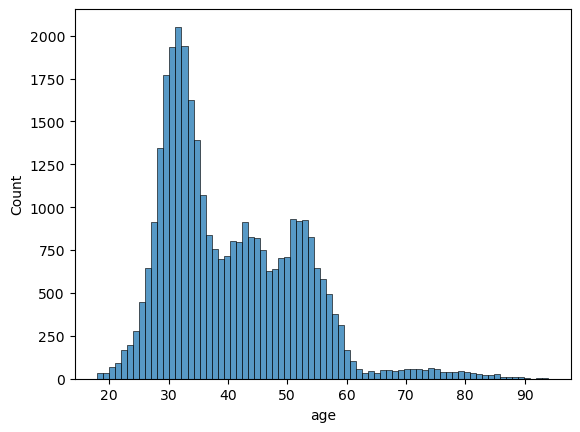

In [16]:
sns.histplot(data=bank_train_data,x="age",bins=75)
plt.show()

/Users/pimawatmingkwan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


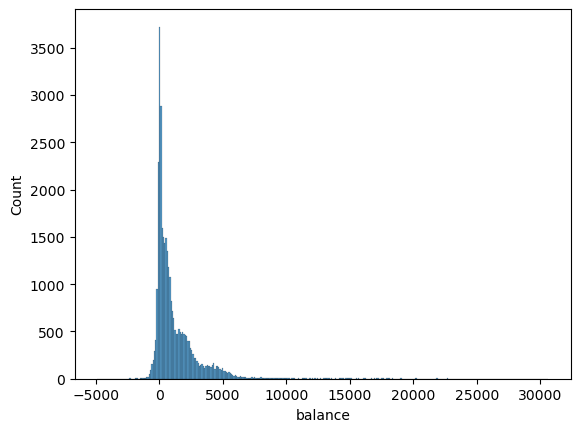

In [17]:
sns.histplot(data=bank_train_data,x="balance")
plt.show()

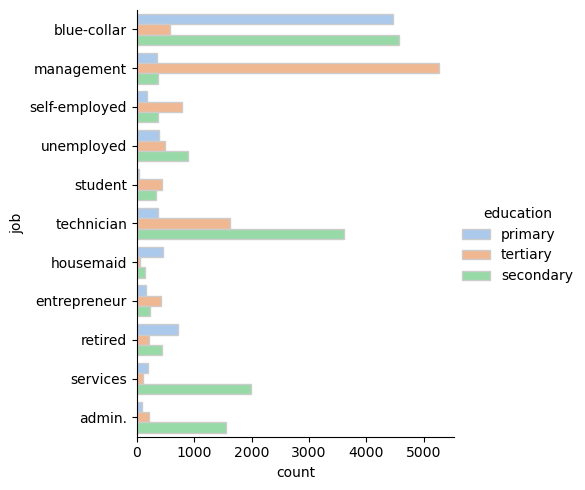

In [18]:
sns.catplot(y="job", hue="education", kind="count",
            palette="pastel", edgecolor=".8",
            data=bank_train_data)

In [19]:
bank_train_data[bank_train_data['education'].isnull()]['job'].value_counts()

job
blue-collar      546
technician       284
retired          205
unemployed       184
management       179
self-employed    110
services          90
entrepreneur      82
admin.            73
housemaid         44
student           36
Name: count, dtype: int64

<Axes: xlabel='education', ylabel='age'>

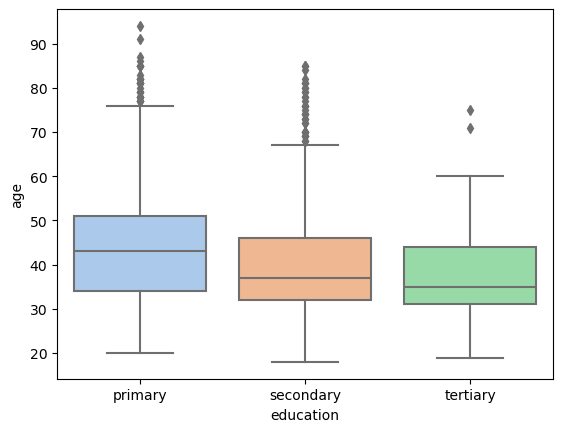

In [20]:
sns.boxplot(data=bank_train_data[bank_train_data['job']=='blue-collar'], x="education", y="age",palette="pastel")

/var/folders/dc/rts3gxy959v0s806sprp248w0000gn/T/ipykernel_68738/1786605315.py:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
/Users/pimawatmingkwan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/Users/pimawatmingkwan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='age', ylabel='education'>

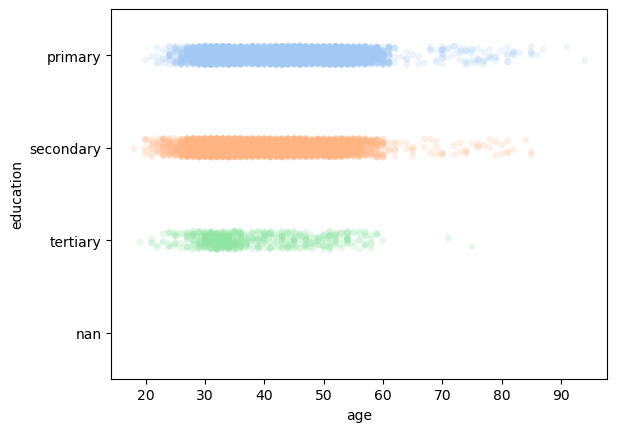

In [21]:
sns.stripplot(data=bank_train_data[bank_train_data['job']=='blue-collar'], 
              x="age", y="education",alpha=0.2,palette="pastel")

In [22]:
# Outlier

# calculate IQR for column Height
Q1 = bank_train_data['balance'].quantile(0.25)
Q3 = bank_train_data['balance'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outliers = bank_train_data[(bank_train_data['balance'] < Q1 - threshold * IQR) |
                               (bank_train_data['balance'] > Q3 + threshold * IQR)]

print("Q1 : " + str(Q1))
print("Q3 : " + str(Q3))

Q1 : 89.0
Q3 : 1728.25


In [23]:
for col in num_col_ls:
    Q1 = bank_train_data[col].quantile(0.25)
    Q3 = bank_train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    threshold = 1.5
    outliers = bank_train_data[(bank_train_data[col] < Q1 - threshold * IQR) | 
                                   (bank_train_data[col] > Q3 + threshold * IQR)]
    
    print(col)
    print("Q1 : " + str(Q1))
    print("Q3 : " + str(Q3))
    print("----------------------")
    
#    bank_train_data = bank_train_data.drop(outliers.index)

age
Q1 : 32.0
Q3 : 49.0
----------------------
balance
Q1 : 89.0
Q3 : 1728.25
----------------------
duration
Q1 : 124.0
Q3 : 292.0
----------------------
campaign
Q1 : 1.0
Q3 : 2.0
----------------------
pdays
Q1 : -1.0
Q3 : 88.0
----------------------
previous
Q1 : 0.0
Q3 : 1.0
----------------------


# Process data

## Data cleaning checklist

1. Data type /
2. Missing value /
3. Duplicate /
4. Outliers /
5. Standardize /
6. Categorical Data /
7. Feature Engineering /

In [24]:
bank_train_data_proc = bank_train_data[:]

In [25]:
bank_train_data_proc.shape

(34000, 18)

### handle missing

#### Missnig value

- job             0.197059 : drop
- education       5.467647 : impute by sub-group / impute by job
- contact        25.673529 : impute by sub-group
- poutcome       74.914706 : impute by sub-group

In [26]:
bank_train_data_proc = bank_train_data_proc.dropna(subset=['job'])

In [27]:
values = {"contact": "unknown", "poutcome": "unknown"}
bank_train_data_proc = bank_train_data_proc.fillna(value=values)

In [28]:
mode_edu_by_job_df = bank_train_data_proc.groupby(['job'])[['education']].agg(pd.Series.mode)
mode_edu_by_job_df

,education
job,
admin.,secondary
blue-collar,secondary
entrepreneur,tertiary
housemaid,primary
management,tertiary
retired,primary
self-employed,tertiary
services,secondary
student,tertiary


In [29]:
index_for_convert_secondary = bank_train_data_proc[((bank_train_data_proc['job'] == 'admin.') | 
                       (bank_train_data_proc['job'] == 'blue-collar') |
                       (bank_train_data_proc['job'] == 'services') |
                       (bank_train_data_proc['job'] == 'technician') |
                       (bank_train_data_proc['job'] == 'unemployed')) & 
                                                   bank_train_data_proc['education'].isnull()].index

index_for_convert_primary = bank_train_data_proc[((bank_train_data_proc['job'] == 'housemaid') | 
                       (bank_train_data_proc['job'] == 'retired')) & 
                                                 bank_train_data_proc['education'].isnull()].index

index_for_convert_tertiary = bank_train_data_proc[((bank_train_data_proc['job'] == 'entrepreneur') | 
                       (bank_train_data_proc['job'] == 'self-employed') |
                       (bank_train_data_proc['job'] == 'management') |
                       (bank_train_data_proc['job'] == 'student')) & 
                                                  bank_train_data_proc['education'].isnull()].index

In [30]:
bank_train_data_proc.loc[index_for_convert_secondary,'education'] = 'secondary'
bank_train_data_proc.loc[index_for_convert_primary,'education'] = 'primary'
bank_train_data_proc.loc[index_for_convert_tertiary,'education'] = 'tertiary'

In [31]:
bank_train_data_proc.isnull().sum()/len(bank_train_data_proc)*100

id             0.0
age            0.0
job            0.0
marital        0.0
education      0.0
default        0.0
balance        0.0
housing        0.0
loan           0.0
contact        0.0
day_of_week    0.0
month          0.0
duration       0.0
campaign       0.0
pdays          0.0
previous       0.0
poutcome       0.0
subscribe      0.0
dtype: float64

In [32]:
len(bank_train_data_proc)

33933

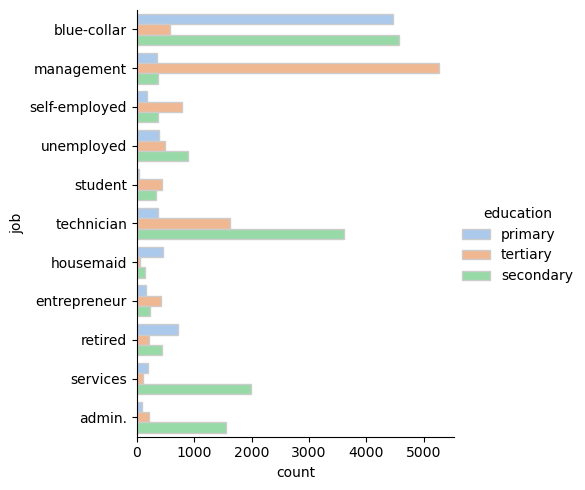

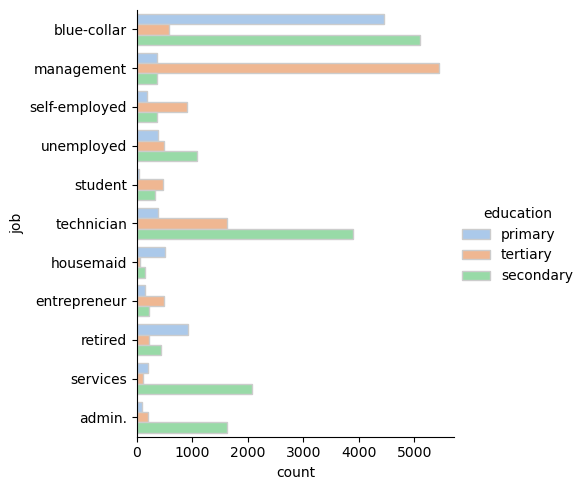

In [33]:
sns.catplot(y="job", hue="education", kind="count",
            palette="pastel", edgecolor=".8",
            data=bank_train_data)

sns.catplot(y="job", hue="education", kind="count",
            palette="pastel", edgecolor=".8",
            data=bank_train_data_proc)

### Outliers

In [34]:
for col in num_col_ls:
    Q1 = bank_train_data_proc[col].quantile(0.10)
    Q3 = bank_train_data_proc[col].quantile(0.90)
    IQR = Q3 - Q1
    
    threshold = 1.5
    outliers = bank_train_data_proc[(bank_train_data_proc[col] < Q1 - threshold * IQR) | 
                                   (bank_train_data_proc[col] > Q3 + threshold * IQR)]
    
    print(col)
    print("Q1 : " + str(Q1))
    print("Q3 : " + str(Q3))
    print("----------------------")
    
    bank_train_data_proc = bank_train_data_proc.drop(outliers.index)

age
Q1 : 29.0
Q3 : 55.0
----------------------
balance
Q1 : -59.0
Q3 : 3389.7999999999993
----------------------
duration
Q1 : 81.0
Q3 : 521.0
----------------------
campaign
Q1 : 1.0
Q3 : 6.0
----------------------
pdays
Q1 : -1.0
Q3 : 258.0
----------------------
previous
Q1 : 0.0
Q3 : 3.0
----------------------


In [35]:
bank_train_data_proc.tail(10)

,id,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,subscribe
33990,15715,27,technician,married,secondary,no,168,yes,yes,unknown,14,may,117,1,-1,0,unknown,no
33991,8981,29,blue-collar,married,secondary,no,-300,yes,yes,cellular,14,may,62,1,-1,0,unknown,no
33992,34097,34,admin.,single,primary,no,599,yes,no,unknown,29,may,149,2,-1,0,unknown,no
33993,2339,30,technician,single,secondary,no,-24,yes,no,unknown,3,jun,225,7,-1,0,unknown,no
33994,4049,50,unemployed,single,secondary,no,1980,no,no,cellular,19,nov,206,1,-1,0,unknown,no
33995,20257,62,retired,married,tertiary,no,164,no,no,cellular,5,oct,373,1,169,7,other,yes
33996,29152,28,blue-collar,single,secondary,yes,571,no,no,unknown,2,jun,63,1,-1,0,unknown,no
33997,19814,28,technician,married,secondary,no,28,yes,yes,telephone,12,jan,177,3,265,1,other,no
33998,25303,47,technician,married,secondary,no,2154,yes,no,cellular,19,nov,140,1,356,2,failure,no
33999,30524,50,blue-collar,married,primary,no,772,no,no,cellular,28,jul,153,1,-1,1,success,no


### Binary cat


In [36]:
bank_train_data_proc['default'] = bank_train_data_proc['default'].str.replace('no','0').replace('yes','1')
bank_train_data_proc['housing'] = bank_train_data_proc['housing'].str.replace('no','0').replace('yes','1')
bank_train_data_proc['loan'] = bank_train_data_proc['loan'].str.replace('no','0').replace('yes','1')
bank_train_data_proc['subscribe'] = bank_train_data_proc['subscribe'].str.replace('no','0').replace('yes','1')

bank_train_data_proc['month'] = bank_train_data_proc['month'].str.replace('jan','1').replace('feb','2').replace('mar','3').replace('apr','4').replace('may','5').replace('jun','6').replace('jul','7').replace('aug','8').replace('sep','9').replace('oct','10').replace('nov','11').replace('dec','12')

In [37]:
bank_train_data_proc.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,subscribe
0,22570,46,blue-collar,married,primary,0,4944,1,0,cellular,14,5,108,1,356,2,failure,0
1,38062,34,management,single,tertiary,0,2115,0,0,cellular,16,11,205,1,93,3,other,1
2,19593,31,blue-collar,single,secondary,0,1151,1,0,cellular,29,4,341,1,-1,0,unknown,1
3,36247,33,self-employed,single,tertiary,0,2730,1,0,telephone,6,6,826,2,-1,0,unknown,0
4,32127,44,management,married,tertiary,1,-171,0,0,cellular,22,8,402,2,-1,0,unknown,0


### Feature Engineering

In [38]:
bank_train_data_proc['first_camp'] = bank_train_data_proc.apply(lambda x: 1 if x['pdays']<0 else 0 , axis=1)

In [39]:
bank_train_data_proc.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,subscribe,first_camp
0,22570,46,blue-collar,married,primary,0,4944,1,0,cellular,14,5,108,1,356,2,failure,0,0
1,38062,34,management,single,tertiary,0,2115,0,0,cellular,16,11,205,1,93,3,other,1,0
2,19593,31,blue-collar,single,secondary,0,1151,1,0,cellular,29,4,341,1,-1,0,unknown,1,1
3,36247,33,self-employed,single,tertiary,0,2730,1,0,telephone,6,6,826,2,-1,0,unknown,0,1
4,32127,44,management,married,tertiary,1,-171,0,0,cellular,22,8,402,2,-1,0,unknown,0,1


In [40]:
dummy_job = pd.get_dummies(bank_train_data_proc['job'],prefix='job',drop_first=True)
dummy_marital = pd.get_dummies(bank_train_data_proc['marital'],prefix='marital',drop_first=True)
dummy_education = pd.get_dummies(bank_train_data_proc['education'],prefix='education',drop_first=True)
dummy_contact = pd.get_dummies(bank_train_data_proc['contact'],prefix='contact',drop_first=True)
dummy_poutcome = pd.get_dummies(bank_train_data_proc['poutcome'],prefix='poutcome',drop_first=True)




bank_train_data_proc_dum = pd.concat([bank_train_data_proc,dummy_job, 
                       dummy_marital,dummy_education,dummy_contact,dummy_poutcome], axis=1)



In [41]:
bank_train_data_proc_dum = bank_train_data_proc_dum.drop(['job','marital','education',
                                                          'contact','poutcome','id'], axis=1)

In [42]:
bank_train_data_proc_dum.head()

,age,default,balance,housing,loan,day_of_week,month,duration,campaign,pdays,...,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,46,0,4944,1,0,14,5,108,1,356,...,False,True,False,False,False,False,False,False,False,False
1,34,0,2115,0,0,16,11,205,1,93,...,False,False,True,False,True,False,False,True,False,False
2,31,0,1151,1,0,29,4,341,1,-1,...,False,False,True,True,False,False,False,False,False,True
3,33,0,2730,1,0,6,6,826,2,-1,...,False,False,True,False,True,True,False,False,False,True
4,44,1,-171,0,0,22,8,402,2,-1,...,False,True,False,False,True,False,False,False,False,True


In [43]:
bank_train_data_proc_dum = bank_train_data_proc_dum.astype('int')

In [44]:
bank_train_data_proc_dum.head()

,age,default,balance,housing,loan,day_of_week,month,duration,campaign,pdays,...,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,46,0,4944,1,0,14,5,108,1,356,...,0,1,0,0,0,0,0,0,0,0
1,34,0,2115,0,0,16,11,205,1,93,...,0,0,1,0,1,0,0,1,0,0
2,31,0,1151,1,0,29,4,341,1,-1,...,0,0,1,1,0,0,0,0,0,1
3,33,0,2730,1,0,6,6,826,2,-1,...,0,0,1,0,1,1,0,0,0,1
4,44,1,-171,0,0,22,8,402,2,-1,...,0,1,0,0,1,0,0,0,0,1


### Standardize

In [45]:
bank_train_data_proc_dum.columns.values

array(['age', 'default', 'balance', 'housing', 'loan', 'day_of_week',
       'month', 'duration', 'campaign', 'pdays', 'previous', 'subscribe',
       'first_camp', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'contact_telephone', 'contact_unknown', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'], dtype=object)

In [46]:
cols = ['age','balance','day_of_week','month','duration','campaign','pdays','previous']

In [47]:
scaler = StandardScaler()
bank_train_data_proc_dum[cols] = scaler.fit_transform(bank_train_data_proc_dum[cols])
bank_train_data_proc_dum.head()

,age,default,balance,housing,loan,day_of_week,month,duration,campaign,pdays,...,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,0.492800,0,2.661127,1,0,-0.044623,-0.512347,-0.706190,-0.580218,2.844707,...,0,1,0,0,0,0,0,0,0,0
1,-0.585812,0,0.708667,0,0,0.198696,1.824458,-0.189664,-0.580218,0.369144,...,0,0,1,0,1,0,0,1,0,0
2,-0.855464,0,0.043353,1,0,1.780274,-0.901815,0.534537,-0.580218,-0.515658,...,0,0,1,1,0,0,0,0,0,1
3,-0.675696,0,1.133115,1,0,-1.017902,-0.122880,3.117165,-0.056702,-0.515658,...,0,0,1,0,1,1,0,0,0,1
4,0.313031,1,-0.869037,0,0,0.928655,0.656055,0.859362,-0.056702,-0.515658,...,0,1,0,0,1,0,0,0,0,1


# Check corr

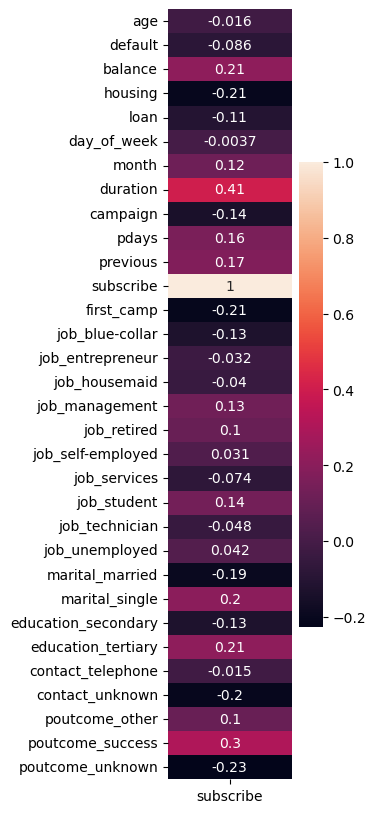

In [48]:
plt.figure(figsize=(2,10))
sns.heatmap(bank_train_data_proc_dum.corr()[['subscribe']], annot=True)
plt.show()

In [49]:
corr_df = bank_train_data_proc_dum.corr()[['subscribe']]

In [50]:
feat_cols = corr_df[(corr_df['subscribe']>=0.1) | (corr_df['subscribe']<=-0.1)].index.values

In [51]:
feat_cols

array(['balance', 'housing', 'loan', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'subscribe', 'first_camp', 'job_blue-collar',
       'job_management', 'job_retired', 'job_student', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'contact_unknown', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [52]:
X = bank_train_data_proc_dum[feat_cols].drop(['subscribe'], axis =1)
y = bank_train_data_proc_dum['subscribe']

In [53]:
y.value_counts()

subscribe
0    24726
1     7118
Name: count, dtype: int64

In [54]:
y.value_counts()/len(X)

subscribe
0    0.776473
1    0.223527
Name: count, dtype: float64

In [55]:
sm = SMOTE(sampling_strategy=0.60)
sm_x,sm_y = sm.fit_resample(X,y)

In [56]:
sm_y.value_counts()

subscribe
0    24726
1    14835
Name: count, dtype: int64

# Sample split

In [57]:
X_train, X_val, y_train, y_val= train_test_split(sm_x, sm_y, test_size =0.2, random_state = 3,stratify=sm_y)

In [58]:
X_train.head()

,balance,housing,loan,month,duration,campaign,pdays,previous,first_camp,job_blue-collar,...,job_retired,job_student,marital_married,marital_single,education_secondary,education_tertiary,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
18983,0.518183,1,0,-1.680750,-0.285514,-0.580218,-0.515658,-0.446731,1,1,...,0,0,0,1,0,0,0,0,0,1
29678,-0.719963,1,0,0.656055,-0.631640,-0.580218,-0.515658,-0.446731,1,0,...,0,0,1,0,0,1,0,0,0,1
34135,0.129944,1,0,-0.511024,-0.865235,-0.580218,-0.515658,-0.446731,1,0,...,0,0,0,1,1,0,1,0,0,1
5084,-0.400419,0,0,0.656055,-0.759440,-0.056702,-0.515658,-0.446731,1,0,...,0,0,1,0,0,0,0,0,0,1
33687,-0.727367,0,0,1.390700,0.647968,-0.580218,-0.515658,-0.446731,1,0,...,1,0,1,0,0,0,0,0,0,1


# Train model

In [59]:
abc = AdaBoostClassifier()
gbdt = GradientBoostingClassifier()
xgb = XGBClassifier()
rf = RandomForestClassifier()

model_ls = [abc,gbdt,xgb,rf]

AdaBoostClassifier()
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      4946
           1       0.77      0.71      0.74      2967

    accuracy                           0.81      7913
   macro avg       0.80      0.79      0.80      7913
weighted avg       0.81      0.81      0.81      7913

--------------------------------------------------------
GradientBoostingClassifier()
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4946
           1       0.81      0.73      0.76      2967

    accuracy                           0.83      7913
   macro avg       0.83      0.81      0.82      7913
weighted avg       0.83      0.83      0.83      7913

--------------------------------------------------------
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stop

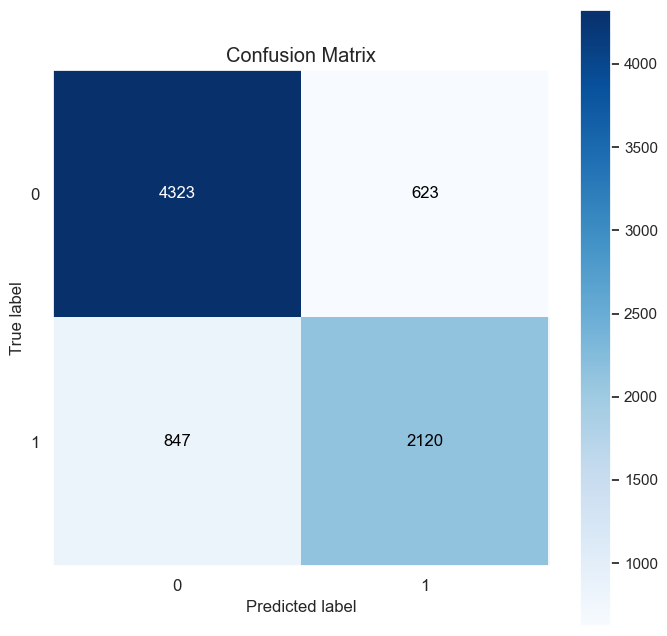

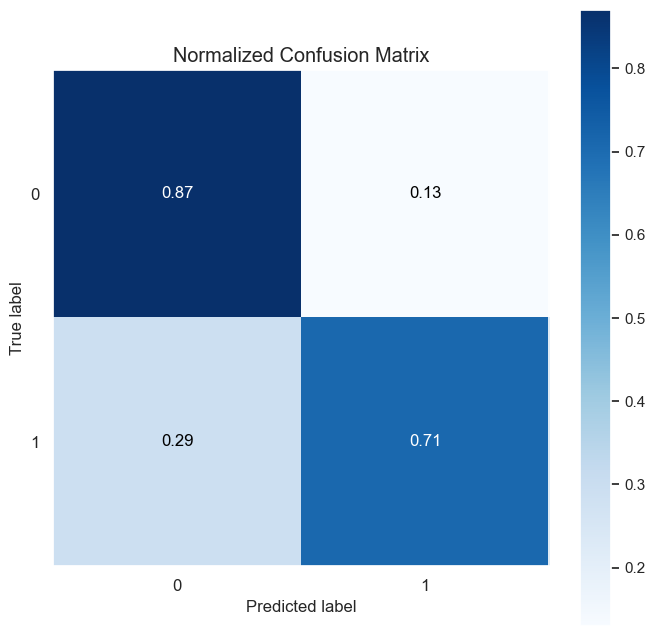

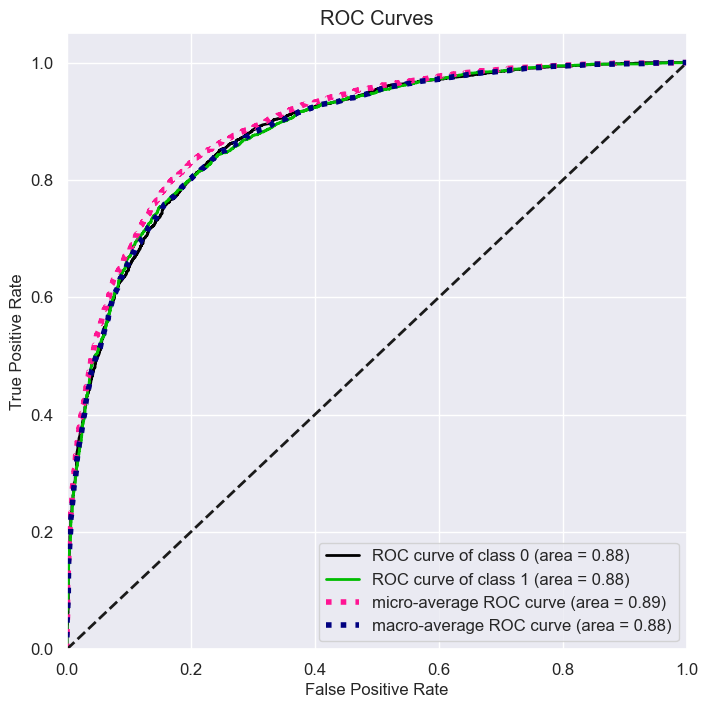

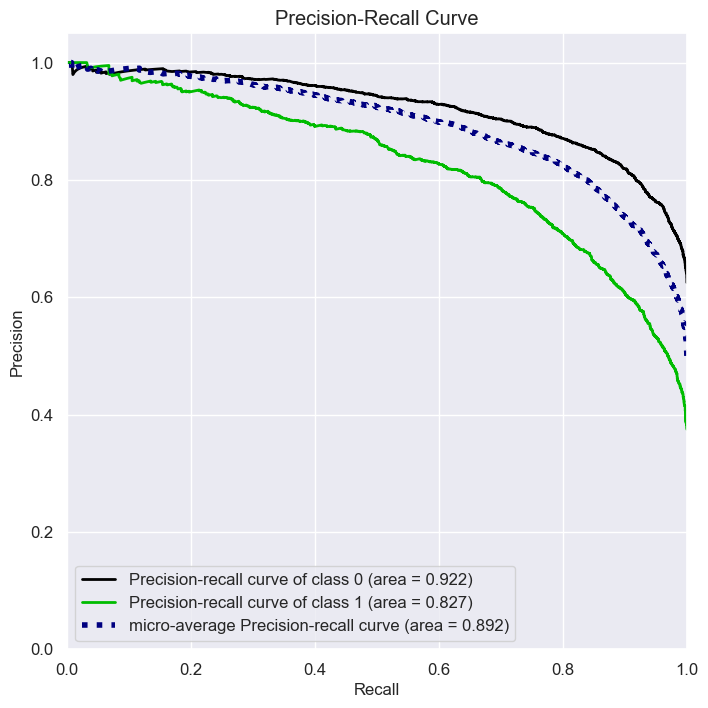

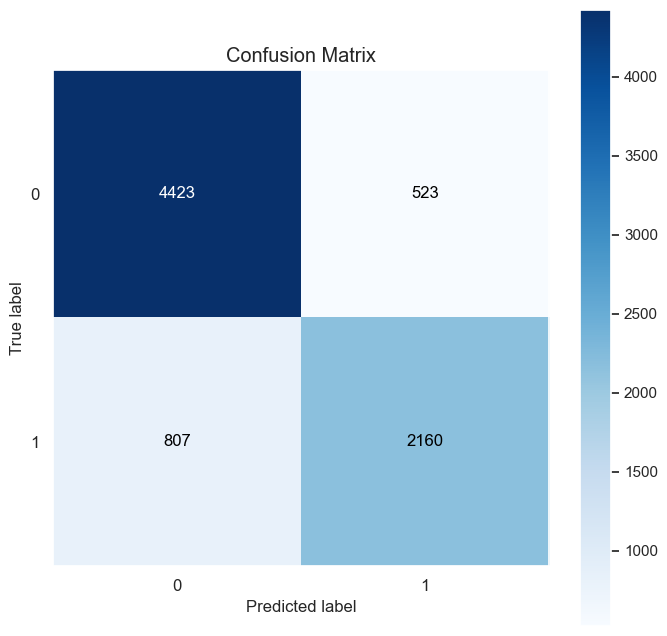

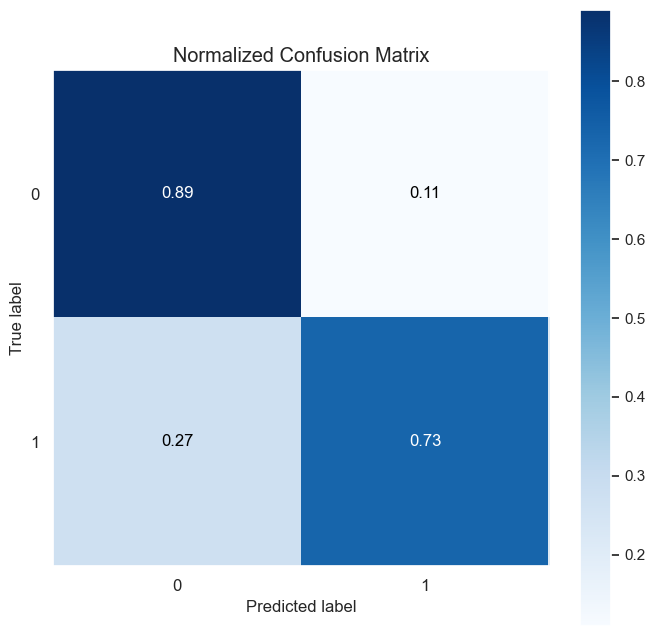

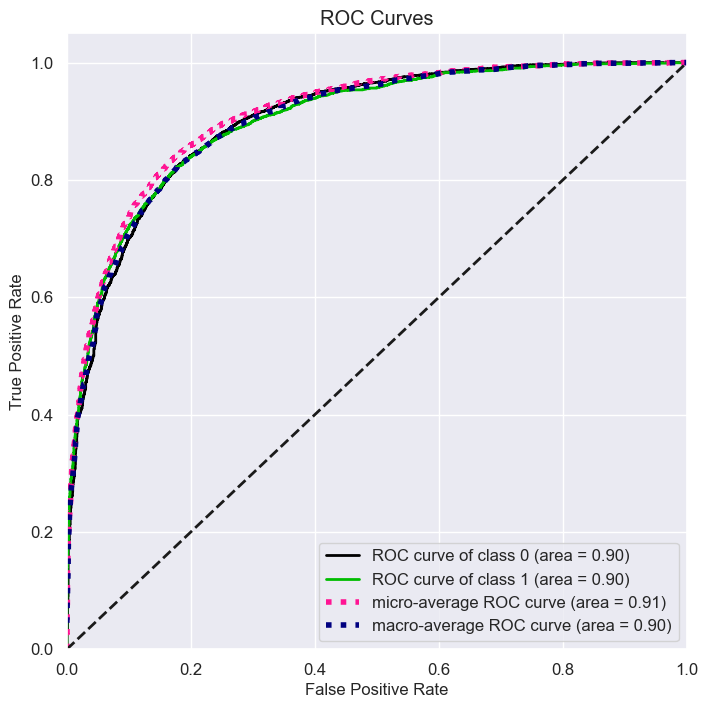

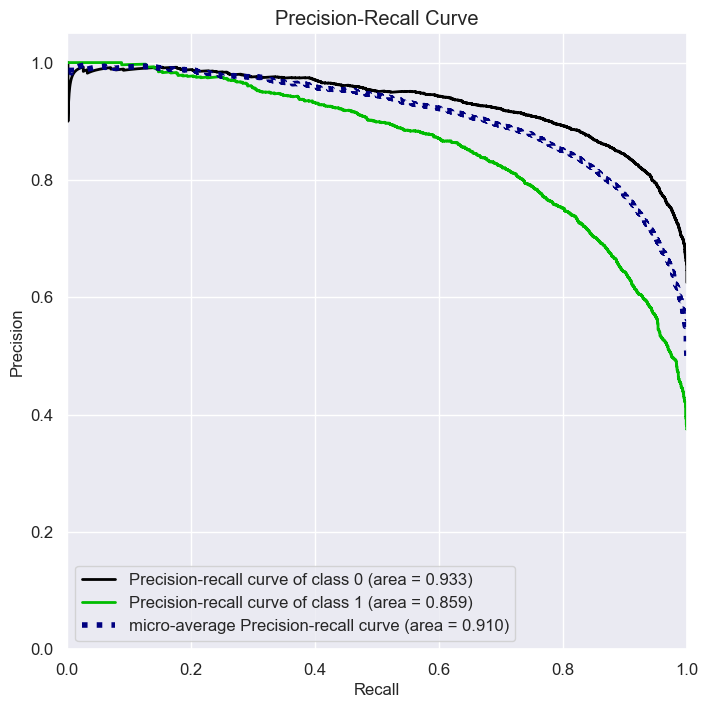

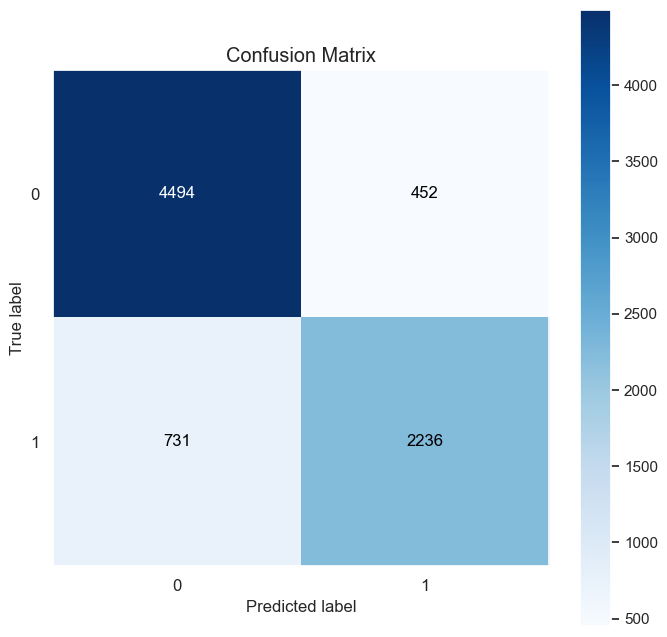

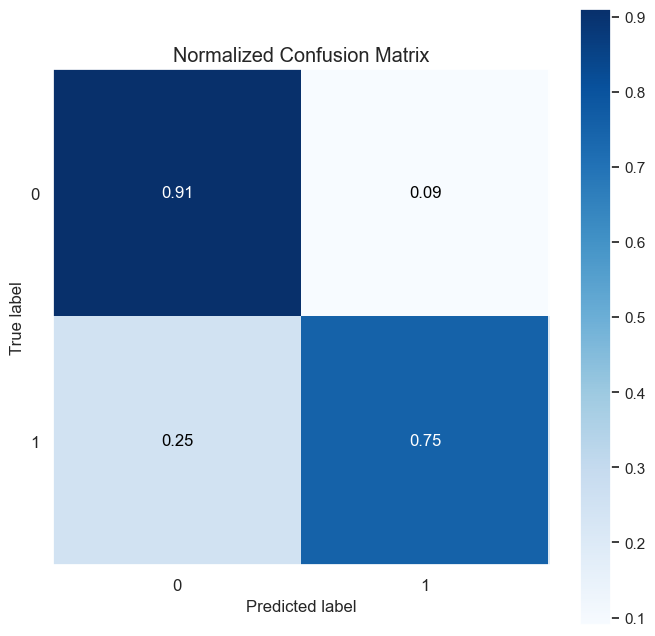

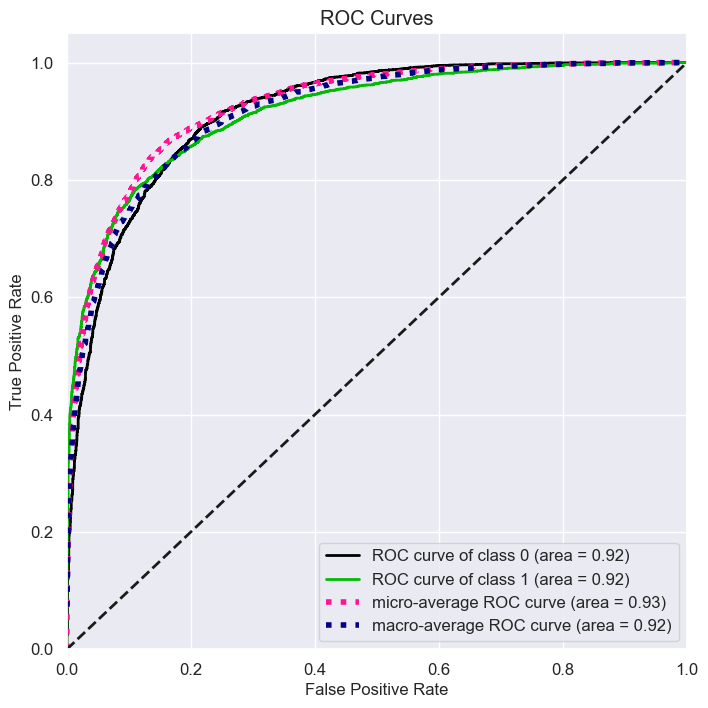

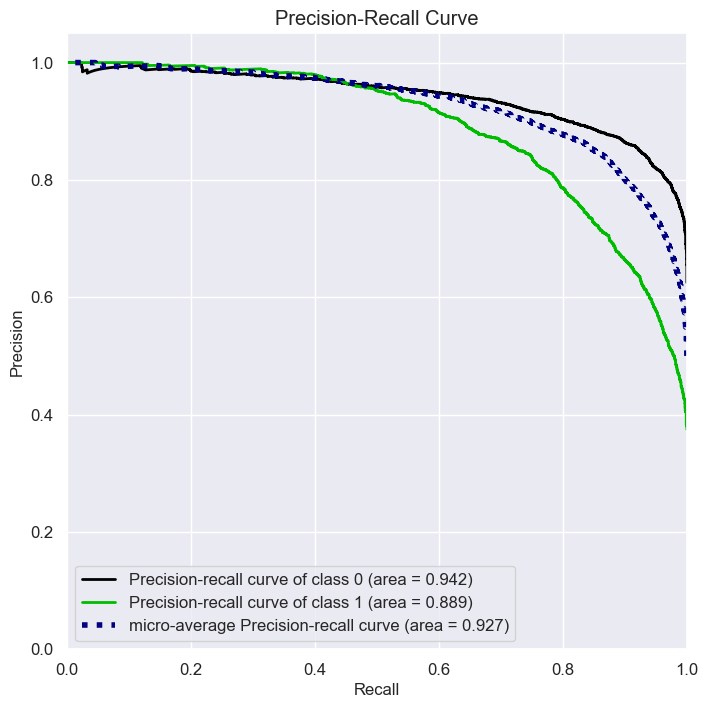

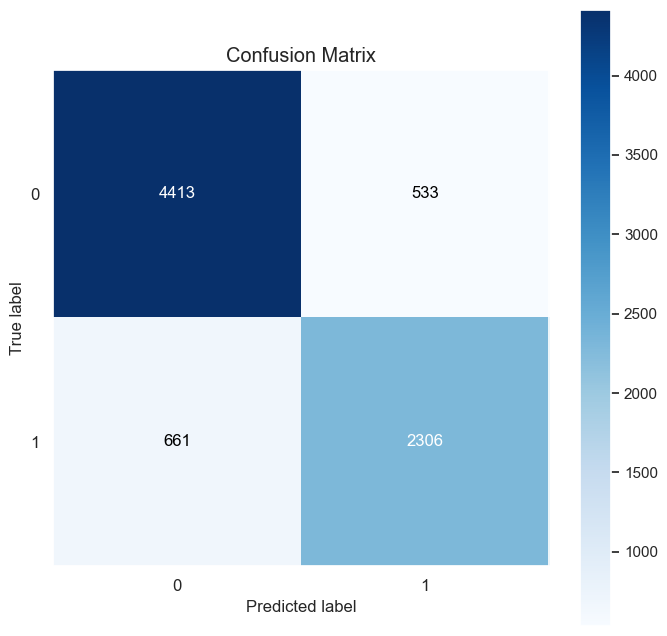

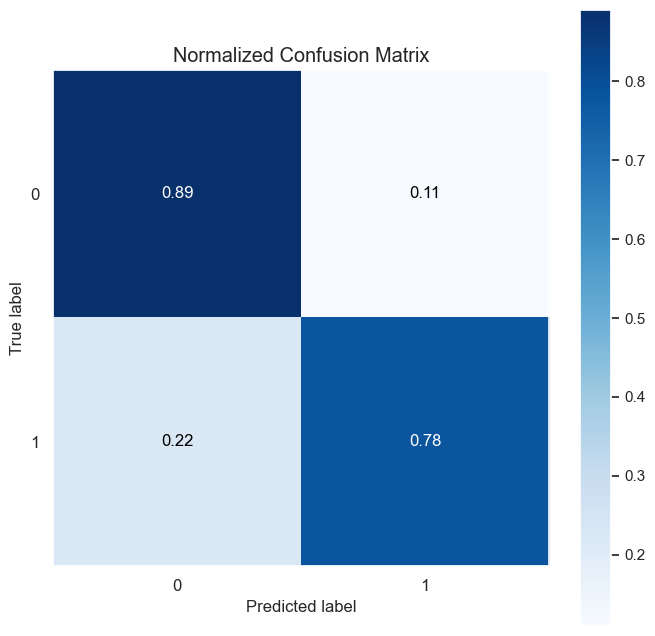

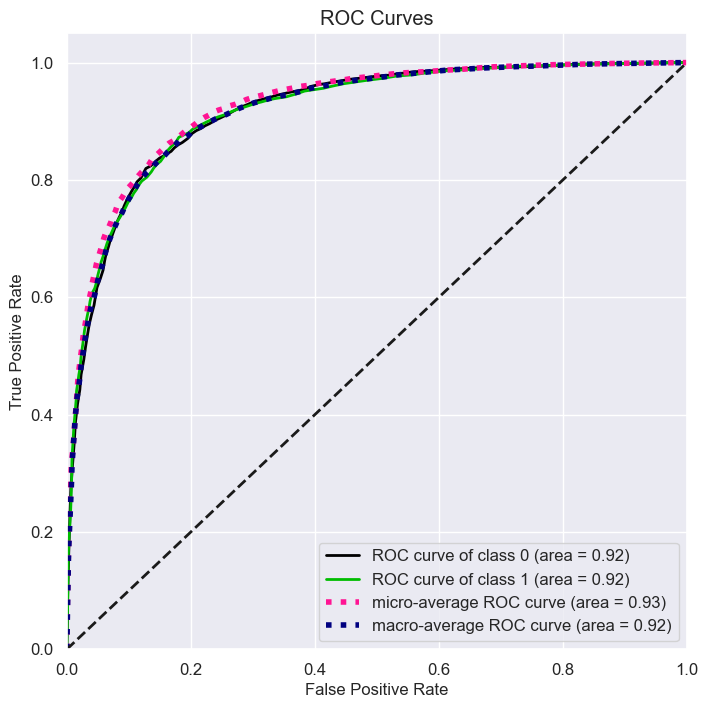

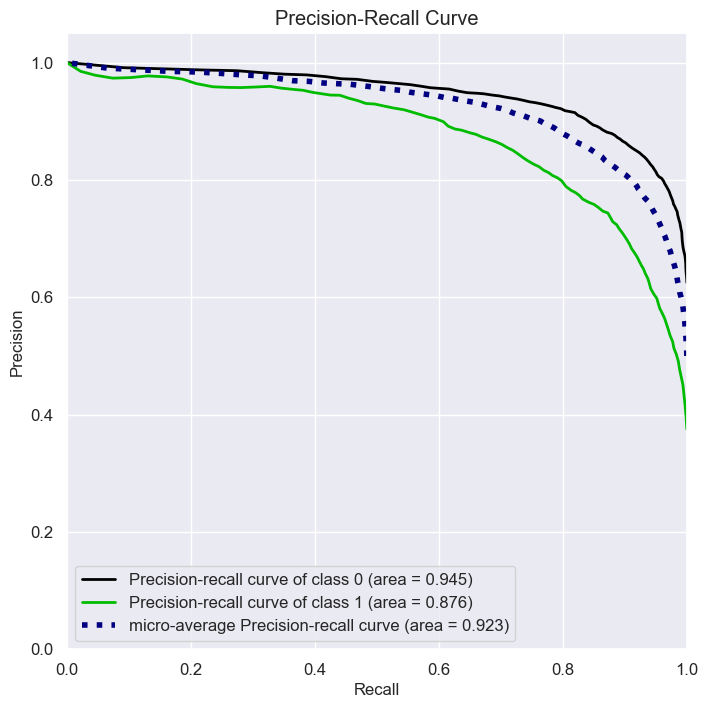

In [60]:
m_ls=['AdaBoost', 
    'GradientBoost',
    'XtremeGradientBoosting',
    'RandomForestClassifier']
acc_ls=[]
f1_ls=[]
confusion_matrix_ls=[]
roc_auc_ls=[]

for m in model_ls:
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_prob = model.predict_proba(X_val)
    
    accuracy = accuracy_score(y_val,y_pred)
    f1 = f1_score(y_val,y_pred)
    confusion_matrix =  cm(y_val,y_pred)
    roc_auc = roc_auc_score(y_val , y_pred)
    
    acc_ls.append(accuracy)
    f1_ls.append(f1)
    confusion_matrix_ls.append(confusion_matrix)
    roc_auc_ls.append(roc_auc)
    
    sns.set(rc={'figure.figsize':(8,8)})
    skplt.metrics.plot_confusion_matrix(y_val , y_pred)
    sns.set(rc={'figure.figsize':(8,8)})
    skplt.metrics.plot_confusion_matrix(y_val , y_pred, normalize=True)
    sns.set(rc={'figure.figsize':(8,8)})
    skplt.metrics.plot_roc(y_val, y_pred_prob)
    sns.set(rc={'figure.figsize':(8,8)})
    skplt.metrics.plot_precision_recall(y_val, y_pred_prob)
    
    print(m)
    print(classification_report(y_val, y_pred))
    print('--------------------------------------------------------')

In [61]:
rf_used = RandomForestClassifier()

In [62]:
rf_used.fit(X_train, y_train)

RandomForestClassifier()

# Process test data set

In [63]:
bank_test_data_proc = bank_test_data[:]

In [64]:
bank_test_data.shape

(8500, 17)

In [65]:
bank_test_data_proc.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,25453,41,self-employed,married,tertiary,no,203,no,no,NaN,29,jan,54,1,-1,0,NaN
1,16750,29,technician,single,secondary,no,-114,yes,yes,NaN,14,may,182,2,-1,0,NaN
2,6235,44,services,married,secondary,no,548,no,no,cellular,14,jul,406,2,-1,0,NaN
3,20804,33,unemployed,single,tertiary,no,2101,yes,no,cellular,14,feb,203,2,180,1,failure
4,6673,57,housemaid,married,secondary,no,2559,no,yes,telephone,8,jul,112,1,-1,0,NaN


In [66]:
bank_test_data_proc['education'].value_counts()

education
secondary    3581
tertiary     2571
primary      1847
Name: count, dtype: int64

In [67]:
values = {"contact": "unknown", "poutcome": "unknown","job":"blue-collar","education":"secondary"}
bank_test_data_proc = bank_test_data_proc.fillna(value=values)

In [68]:
bank_test_data_proc.isnull().sum()

id             0
age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day_of_week    0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
dtype: int64

In [69]:
bank_test_data_proc['default'] = bank_test_data_proc['default'].str.replace('no','0').replace('yes','1')
bank_test_data_proc['housing'] = bank_test_data_proc['housing'].str.replace('no','0').replace('yes','1')
bank_test_data_proc['loan'] = bank_test_data_proc['loan'].str.replace('no','0').replace('yes','1')

bank_test_data_proc['month'] = bank_test_data_proc['month'].str.replace('jan','1').replace('feb','2').replace('mar','3').replace('apr','4').replace('may','5').replace('jun','6').replace('jul','7').replace('aug','8').replace('sep','9').replace('oct','10').replace('nov','11').replace('dec','12')


In [70]:
bank_test_data_proc['first_camp'] = bank_test_data_proc.apply(lambda x: 1 if x['pdays']<0 else 0 , axis=1)

In [71]:
dummy_job = pd.get_dummies(bank_test_data_proc['job'],prefix='job',drop_first=True)
dummy_marital = pd.get_dummies(bank_test_data_proc['marital'],prefix='marital',drop_first=True)
dummy_education = pd.get_dummies(bank_test_data_proc['education'],prefix='education',drop_first=True)
dummy_contact = pd.get_dummies(bank_test_data_proc['contact'],prefix='contact',drop_first=True)
dummy_poutcome = pd.get_dummies(bank_test_data_proc['poutcome'],prefix='poutcome',drop_first=True)




bank_test_data_proc_dum = pd.concat([bank_test_data_proc,dummy_job, 
                       dummy_marital,dummy_education,dummy_contact,dummy_poutcome], axis=1)

bank_test_data_proc_dum = bank_test_data_proc_dum.drop(['job','marital','education',
                                                          'contact','poutcome','id'], axis=1)

In [72]:
bank_test_data_proc_dum = bank_test_data_proc_dum.astype('int')

In [73]:
bank_test_data_proc_dum[cols] = scaler.transform(bank_test_data_proc_dum[cols])
bank_test_data_proc_dum.head()

,age,default,balance,housing,loan,day_of_week,month,duration,campaign,pdays,...,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,0.043378,0,-0.610917,0,0,1.780274,-2.070217,-0.993740,-0.580218,-0.515658,...,0,1,0,0,1,0,1,0,0,1
1,-1.035233,0,-0.829698,1,1,-0.044623,-0.512347,-0.312140,-0.056702,-0.515658,...,0,0,1,1,0,0,1,0,0,1
2,0.313031,0,-0.372813,0,0,-0.044623,0.266588,0.880662,-0.056702,-0.515658,...,0,1,0,1,0,0,0,0,0,1
3,-0.675696,0,0.699005,1,0,-0.044623,-1.680750,-0.200314,-0.056702,1.188057,...,1,0,1,0,1,0,0,0,0,0
4,1.481527,0,1.015097,0,1,-0.774582,0.266588,-0.684890,-0.580218,-0.515658,...,0,1,0,1,0,1,0,0,0,1


In [74]:
test_feat_cols = ['balance', 'housing', 'loan', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'first_camp', 'job_blue-collar',
       'job_management', 'job_retired', 'job_student', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'contact_unknown', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown']

In [75]:
X_test = bank_test_data_proc_dum[test_feat_cols]

# Predict test dataset

In [76]:
pred_test = rf_used.predict(X_test)

In [77]:
sample_sub.head()

,id,subscribe
0,1,no
1,2,no
2,3,no
3,4,yes
4,5,no


In [78]:
pred_result = pd.DataFrame({'id': bank_test_data_proc['id'], 
                   'subscribe': pred_test})

In [79]:
pred_result['subscribe'] = pred_result.apply(lambda x: 'yes' if x['subscribe']==1 else 'no' , axis=1)

In [80]:
pred_result.tail()

,id,subscribe
8495,15457,no
8496,1007,no
8497,11454,yes
8498,42315,no
8499,34750,no


In [81]:
pred_result.to_csv('submission.csv', index=False)